# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing (Personality chat datasets)

## 1.1. Download Dataset (Personality chat datasets)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download datasets

id = '15ffr21SsiQXCe5zcTid7uhF8IDOsLb0F'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_professional.tsv') 

id = '1uXUv43oI6FlKyjaFC1LUQVDLdH8m1Uii'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_friend.tsv')

id = '1V5GqCAdaTCiJTyL0pfhZmBJe77Vrcc0c'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_comic.tsv')

# read datasets

df1 = pd.read_csv('qna_chitchat_the_professional.tsv', sep="\t")
df2 = pd.read_csv('qna_chitchat_the_friend.tsv', sep="\t")
df3 = pd.read_csv('qna_chitchat_the_comic.tsv', sep="\t")

    100% |████████████████████████████████| 993kB 16.8MB/s 


## 1.2. Preprocess data (Personality chat datasets)

For questions, I implement five steps to preprocess them.

The first step is to decapitalize the text. Because the first letter the first word of a sentence is usually capitalized. If using the origin text for further model, these first-letter-capitalized words will be recognized as different ones from the decapitalized words.

The second step is to remove contractions. This step is implemented for two reasons. Firstly, removing contractions can avoid unnecessary recognition. For example, "can't" and "cannot" will be recognized as the same pattern after implementing this action. Secondly, this step is also a preprocessing for the next step. I will explain it in the instruction of the forth step.

The third step is to remove punctuations. Punctuations have no actual meanings.

The forth step is to remove stopwords. Because stopwords often don't really important to the main meaning of the sentences. So removing stopwords is a method to extract the core parts from the sentences.

The last step is to tokenize the question. I need to get a list of individual tokens in the question.

For answers, because we choose N to One model, I regard a whole answer as a single token. 

In [0]:
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from gensim.models import Word2Vec
from lxml import etree

# remove contractions

def remove_contraction(x):
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    x = str(x)
    for contraction in contraction_dict:
        if contraction in x:
            x = x.replace(contraction, contraction_dict[contraction])
    return x
  
# Sequence data
# Generate unique tokens list from qas.json

def seq_preprocess(file):
  seq_data = []
  whole_words = []
  max_input_words_amount = 0
  
  for index, row in file.iterrows():

      # preprocess data
      question = row['Question']
      answer = row['Answer']

      # decapitalization
      question = question.lower()
      
      # remove contractions
      question = remove_contraction(question)
      
      # remove punctuations
      question = re.sub(r'[^\w\s]',' ',question)
      
      # remove stopwords
      question = remove_stopwords(question)

      # we need to tokenise question    
      tokenized_q = word_tokenize(question)

      # we do not need to tokenise answer (because we implement N to One model)
      # make a list with only one element (whole sentence)      
      tokenized_a = [answer]

      seq_data.append([tokenized_q, tokenized_a])
      
      # add answer list      
      whole_words += tokenized_a

      # we need to decide the maximum size of input word tokens      
      max_input_words_amount = max(len(tokenized_q), max_input_words_amount)


  # we now have a vocabulary list of answers  
  unique_words = sorted(list(set(whole_words)))

  # adding special tokens in the vocabulary list    
  # _B_: Beginning of Sequence
  # _E_: Ending of Sequence
  # _U_: Unknown element of Sequence - for different size input
  unique_words.append('_B_')
  unique_words.append('_E_')
  unique_words.append('_U_')

  # make dictionary so that we can be reference each index of unique word  
  num_dic = {n: i for i, n in enumerate(unique_words)}
  dic_len = len(num_dic)
  
  return seq_data, unique_words, num_dic, dic_len, max_input_words_amount



/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2 - Model Implementation

## 2.1. Word Embeddings

In these section, I choose to implement Word2Vec with SkipGram via Tensorflow. 
First of all, although FastText can train the model faster and can deal with words which are not in the training vocabulary dictionary, it will loss the sequence information between words.  So I choose Word2Vec.
Secondly, in SkipGram procedure, every word is influenced by its context words. So all the words will be equally predicted and adjusted for K times (K is the window size) when being the center word. Although, in CBOW, some words may also be influenced by the context words for several times when being cotained in several windows, the adjustment of the word is working along with the context words. The result after Gradient Decent will be equally divided to this word. So some words may not be trained for enough times. As the training datasets of this project are not really big and there are so many rare words in the datasets (the word frequency distribution is shown as the figure below), SkipGram may perform better than CBOW. 

![](https://drive.google.com/uc?export=view&id=10ClS7haXJNf4faz3yAfJIfhVcahNUnrv)

### 2.1.1. Download Dataset for Word Embeddings



Here, I also use the Microsoft BotBuilder chat datasets because they are the training datasets of my chatbot. Using these datasets to do word embedding can focusing better on the qustions applied to my chatbot.

### 2.1.2. Data Preprocessing for Word Embeddings

Because in the Sequence-to-Sequence section, I tokenize the questions and make a whole answer as a single token, I just need to embed the question tokens in this section.

The first step is to decapitalize the text. Because the first letter the first word of a sentence is usually capitalized. If using the origin text for further model, these first-letter-capitalized words will be recognized as different ones from the decapitalized words.

The second step is to remove contractions. Removing contractions can avoid unnecessary recognition. For example, "can't" and "cannot" will be recognized as the same pattern after implementing this action.

The third step is to remove punctuations. Punctuations have no actual meanings.

The last step is to tokenize the question. I need to get a list of individual tokens in the question.

Here I don't remove the stopwords because I don't need to extract the main meaning of a sentence. What I need is to train all the words and to keep the sequence information of the words in a sentence. 

In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

word_sequence = []

for index, row in df1.iterrows():
    
    # preprocess data    
    question1 = row['Question']
    
    # decapitalization
    question1 = question1.lower()
    
    # remove contractions
    question1 = remove_contraction(question1)
    
    # remove punctuations
    question1 = re.sub(r'[^\w\s]',' ',question1)
    
    # tokenize the sentence
    tokenized_q1 = word_tokenize(question1)
    
    # add question list   
    word_sequence += tokenized_q1
    
for index, row in df2.iterrows():
    
    # preprocess data
    question2 = row['Question']
    
    question2 = question2.lower()
    question2 = remove_contraction(question2)
    question2 = re.sub(r'[^\w\s]',' ',question2)
    
    tokenized_q2 = word_tokenize(question2)
    
    # add question list    
    word_sequence += tokenized_q2
    
for index, row in df3.iterrows():
    
    # preprocess data
    question3 = row['Question']

    question3 = question3.lower()
    question3 = remove_contraction(question3)
    question3 = re.sub(r'[^\w\s]',' ',question3)
    
    tokenized_q3 = word_tokenize(question3)
    
    # add question list    
    word_sequence += tokenized_q3

# we now have a vocabulary list
word_list = sorted(list(set(word_sequence)))



# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# Making window size 1 skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
  
    # (context, target) : ([target index - 1, target index + 1], target)    
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # skipgrams - (target, context[0]), (target, context[1])..  
    for w in context:
        skip_grams.append([target, w])



In [2]:
print (word_sequence)

['what', 'is', 'your', 'age', 'are', 'you', 'young', 'when', 'were', 'you', 'born', 'what', 'age', 'are', 'you', 'are', 'you', 'old', 'how', 'old', 'are', 'you', 'how', 'long', 'ago', 'were', 'you', 'born', 'ask', 'me', 'anything', 'ask', 'me', 'a', 'question', 'can', 'you', 'ask', 'me', 'a', 'question', 'ask', 'me', 'something', 'what', 'do', 'you', 'want', 'to', 'know', 'about', 'me', 'can', 'you', 'sleep', 'do', 'you', 'have', 'boogers', 'do', 'not', 'you', 'ever', 'sleep', 'do', 'you', 'dream', 'do', 'you', 'smell', 'do', 'you', 'sweat', 'do', 'you', 'get', 'tired', 'can', 'you', 'sneeze', 'getting', 'tired', 'of', 'you', 'you', 'bore', 'me', 'i', 'am', 'tired', 'of', 'you', 'you', 'are', 'so', 'basic', 'basic', 'af', 'you', 'are', 'no', 'fun', 'be', 'more', 'fun', 'why', 'are', 'you', 'so', 'boring', 'you', 'are', 'so', 'boring', 'you', 'are', 'boring', 'you', 'do', 'not', 'interest', 'me', 'at', 'all', 'why', 'are', 'you', 'so', 'boring', 'you', 'are', 'really', 'boring', 'you', 

In [3]:
dict1 = {}
for key in word_sequence:
  dict1[key] = dict1.get(key, 0) + 1

print (dict1)

{'what': 219, 'is': 207, 'your': 114, 'age': 6, 'are': 441, 'you': 1065, 'young': 3, 'when': 6, 'were': 12, 'born': 6, 'old': 6, 'how': 72, 'long': 3, 'ago': 3, 'ask': 18, 'me': 189, 'anything': 12, 'a': 222, 'question': 9, 'can': 90, 'something': 30, 'do': 345, 'want': 39, 'to': 105, 'know': 57, 'about': 42, 'sleep': 9, 'have': 69, 'boogers': 3, 'not': 102, 'ever': 15, 'dream': 3, 'smell': 3, 'sweat': 3, 'get': 21, 'tired': 18, 'sneeze': 3, 'getting': 6, 'of': 60, 'bore': 3, 'i': 387, 'am': 189, 'so': 90, 'basic': 6, 'af': 3, 'no': 15, 'fun': 6, 'be': 54, 'more': 15, 'why': 27, 'boring': 18, 'interest': 3, 'at': 9, 'all': 12, 'really': 21, 'could': 9, 'honestly': 3, 'uninteresting': 3, 'lame': 3, 'who': 60, 'boss': 9, 'master': 3, 'the': 45, 'name': 24, 'report': 3, 'cook': 3, 'spend': 6, 'time': 9, 'in': 33, 'garden': 3, 'high': 12, 'jump': 3, 'play': 6, 'games': 3, 'fly': 3, 'make': 9, 'sandwich': 3, 'read': 3, 'my': 72, 'mind': 6, 'count': 6, 'million': 3, 'sports': 3, 'help': 6, '

In [9]:
freq = []
for key, values in dict1.items():
  freq.append(values)
print(freq)

[219, 207, 114, 6, 441, 1065, 3, 6, 12, 6, 6, 72, 3, 3, 18, 189, 12, 222, 9, 90, 30, 345, 39, 105, 57, 42, 9, 69, 3, 102, 15, 3, 3, 3, 21, 18, 3, 6, 60, 3, 387, 189, 90, 6, 3, 15, 6, 54, 15, 27, 18, 3, 9, 12, 21, 9, 3, 3, 3, 60, 9, 3, 45, 24, 3, 3, 6, 9, 33, 3, 12, 3, 6, 3, 3, 9, 3, 3, 72, 6, 6, 3, 3, 6, 33, 3, 3, 6, 3, 27, 15, 9, 21, 12, 3, 12, 3, 3, 3, 9, 9, 3, 3, 3, 6, 3, 3, 3, 27, 3, 3, 6, 6, 6, 6, 6, 6, 6, 24, 33, 9, 3, 3, 18, 12, 6, 6, 57, 3, 27, 3, 18, 15, 21, 9, 18, 9, 3, 3, 3, 21, 3, 3, 27, 6, 3, 12, 3, 3, 3, 3, 6, 3, 18, 9, 6, 3, 21, 3, 27, 9, 9, 3, 3, 72, 3, 9, 3, 3, 9, 54, 3, 6, 6, 18, 6, 3, 3, 3, 3, 3, 18, 3, 9, 45, 6, 12, 6, 3, 3, 24, 3, 6, 15, 3, 6, 12, 3, 6, 6, 6, 12, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 21, 9, 9, 3, 3, 3, 6, 6, 3, 3, 6, 6, 6, 3, 3, 12, 9, 12, 30, 6, 3, 3, 15, 3, 6, 12, 12, 9, 3, 3, 6, 6, 6, 6, 3, 3, 3, 6, 3, 21, 6, 9, 18, 12, 3, 15, 12, 3, 3, 3, 15, 6, 12, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 3, 6, 3, 27, 36, 15, 9, 6, 3, 3, 3, 3, 30, 6, 6, 9, 1

(array([485.,  12.,   2.,   3.,   2.,   0.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   3. ,   56.1,  109.2,  162.3,  215.4,  268.5,  321.6,  374.7,
         427.8,  480.9,  534. ,  587.1,  640.2,  693.3,  746.4,  799.5,
         852.6,  905.7,  958.8, 1011.9, 1065. ]),
 <a list of 20 Patch objects>)

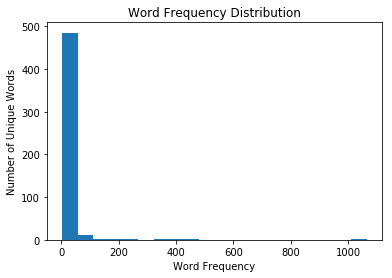

In [12]:
plt.xlabel('Word Frequency')
plt.ylabel('Number of Unique Words')
plt.title('Word Frequency Distribution')
plt.hist(freq, bins = 20)

### 2.1.3. Build Word Embeddings Model

I set learning_rate to be 0.01.

The batch_size is better be 64 or 128. So I choose 128 here. And I set sample_size to be 64, which is half of the batch_size.

The embedding_size is better be in the range of 100 to 300. So I choose 100 here.

According to the figure bellow, when the Epoch number is larger than 500, the cost will not change too much. So I choose 2000 to be the total number of Epochs.


![](https://drive.google.com/uc?export=view&id=1n28vg5EZJjAdzsuyVSiUcy_YoQwQ4INU)

In [0]:
def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
      random_inputs.append(data[i][0]) # target
      random_labels.append([data[i][1]]) # context word

    return random_inputs, random_labels

# Setting Hyperparameters
learning_rate = 0.01
batch_size = 128
embedding_size = 100

# sampling size for nce_loss function (cost function)
# must be lower than batch_size
sample_size = 64

voc_size = len(word_list)


inputs = tf.placeholder(tf.int32, shape=[batch_size])
# placeholder (output) of function tf.nn.nce_loss()
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec Model
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# i.e.)  embeddings       inputs       selected
#       [[1, 2, 3]   ->   [2, 3]   -> [[2, 3, 4]
#        [2, 3, 4]                    [3, 4, 5]]
#        [3, 4, 5]
#        [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# weight and bias for nce_loss() function
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

cost_op = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, sample_size, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)


### 2.1.4. Train Word Embeddings Model

Epoch 0, Cost= 147.9759
Epoch 100, Cost= 11.7114
Epoch 200, Cost= 5.4738
Epoch 300, Cost= 3.4934
Epoch 400, Cost= 2.9347
Epoch 500, Cost= 2.7443
Epoch 600, Cost= 2.5152
Epoch 700, Cost= 2.4497
Epoch 800, Cost= 1.9869
Epoch 900, Cost= 2.4502
Epoch 1000, Cost= 1.7593
Epoch 1100, Cost= 1.4703
Epoch 1200, Cost= 1.9731
Epoch 1300, Cost= 2.1200
Epoch 1400, Cost= 2.2736
Epoch 1500, Cost= 1.8832
Epoch 1600, Cost= 1.7874
Epoch 1700, Cost= 1.9743
Epoch 1800, Cost= 1.8068
Epoch 1900, Cost= 1.7364
Epoch 2000, Cost= 2.7846
Epoch 2100, Cost= 2.1668
Epoch 2200, Cost= 1.6835
Epoch 2300, Cost= 1.9144
Epoch 2400, Cost= 1.8151
Epoch 2500, Cost= 1.8149
Epoch 2600, Cost= 1.8034
Epoch 2700, Cost= 2.1330
Epoch 2800, Cost= 1.9164
Epoch 2900, Cost= 1.7549
Epoch 3000, Cost= 1.5729
Epoch 3100, Cost= 1.6515
Epoch 3200, Cost= 1.5395
Epoch 3300, Cost= 1.8220
Epoch 3400, Cost= 2.5400
Epoch 3500, Cost= 1.8284
Epoch 3600, Cost= 1.6516
Epoch 3700, Cost= 1.8558
Epoch 3800, Cost= 1.7243
Epoch 3900, Cost= 1.7426


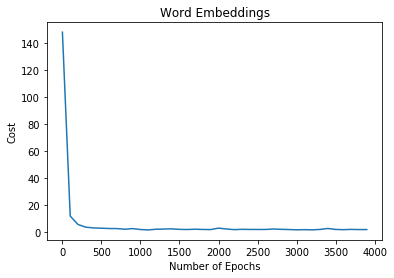

In [0]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    no_of_epochs = 2000
    display_interval = 100
    epoch_num = []
    cost_num = []
    for epoch in range(no_of_epochs):
        batch_inputs, batch_labels = prepare_batch(skip_grams, batch_size)
        sess.run(train_op, feed_dict={inputs:batch_inputs, labels:batch_labels})    

        if epoch % display_interval == 0 :
            # calculate the cost/accuracy of the current model
            cost = sess.run(cost_op, feed_dict={inputs:batch_inputs,
                                                  labels:batch_labels})
            print("Epoch " + str(epoch) + ", Cost= " + 
                    "{:.4f}".format(cost))
            epoch_num.append(epoch)
            cost_num.append(cost)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Cost')
    plt.title('Word Embeddings')
    plt.plot(epoch_num, cost_num)
    plt.show()

    # assign the learned embeddings for display on matplot
    # within 'with'  you can use eval() instead of sess.run()
    trained_embeddings = embeddings.eval()
    saver.save(sess, 'word_embeddings_model.cpkt')

### 2.1.5. Save Word Embeddings Model

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# upload word embeddings model
upload1 = drive.CreateFile({'title': 'word_embeddings_model.cpkt.data-00000-of-00001'})
upload1.SetContentFile('word_embeddings_model.cpkt.data-00000-of-00001')
upload1.Upload()
print (upload1['id'])

upload2 = drive.CreateFile({'title': 'word_embeddings_model.cpkt.index'})
upload2.SetContentFile('word_embeddings_model.cpkt.index')
upload2.Upload()
print (upload2['id'])

upload3 = drive.CreateFile({'title': 'word_embeddings_model.cpkt.meta'})
upload3.SetContentFile('word_embeddings_model.cpkt.meta')
upload3.Upload()
print (upload3['id'])


14s1NsUiNyFjyx7O6W4B6rdVqpeI2m9Rn
1sADgG4xg0p3oucRQKtJqVmsKIjngDicP
1RyEf06Jw1mb1EadOJWusm7wN0BJLfaJG


### 2.1.6. Load Word Embeddings Model

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download word embeddings model
id = '14s1NsUiNyFjyx7O6W4B6rdVqpeI2m9Rn'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.data-00000-of-00001') 

id = '1sADgG4xg0p3oucRQKtJqVmsKIjngDicP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.index')

id = '1RyEf06Jw1mb1EadOJWusm7wN0BJLfaJG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.meta')
    
saver = tf.train.Saver()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    
    # Restore (Load) the model
    saver.restore(sess, "./word_embeddings_model.cpkt")
    trained_embeddings = embeddings.eval()

    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./word_embeddings_model.cpkt


## 2.2. Seq2Seq model

### 2.2.1. Apply/Import Word Embedding Model

In [0]:
# get token index vector of questions and add paddings if the word is shorter than the maximum number of words
def get_vectors_q(tokenized_sentence, max_input_words_amount):
    
    
    diff = max_input_words_amount - len(tokenized_sentence)
    
    # add paddings if the word is shorter than the maximum number of words    
    for x in range(diff):
        tokenized_sentence.append('_P_')
        
        
    data = tokens_to_ids1(tokenized_sentence)
    
        
    return data

# get token index vector of answer
def get_vectors_a(tokenized_sentence, num_dic):    
    data = tokens_to_ids2(tokenized_sentence, num_dic)
    
    return data
    

# convert question tokens to vectors
def tokens_to_ids1(tokenized_sentence):
    ids = []

    for token in tokenized_sentence:
        if token in word_dict.keys():
            ids.append(trained_embeddings[word_dict[token]])
        else:
            ids.append([0]*embedding_size)

    return ids
  
# convert tokens to index
def tokens_to_ids2(tokenized_sentence, num_dic):
    ids = []

    for token in tokenized_sentence:
        ###<You need to fill here>###
        if token in num_dic:
            ids.append(num_dic[token])
        else:
            ids.append(num_dic['_U_'])
        ###</You need to fill here>###      

    return ids

# generate a batch data for training/testing
def make_batch(dic_len, seq_data, num_dic, max_input_words_amount):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in seq_data:        
        # Input for encoder cell, convert question to vector
        input_data = get_vectors_q(seq[0], max_input_words_amount)
        
        # Input for decoder cell, Add '_B_' at the beginning of the sequence data
        output_data = [num_dic['_B_']]
        output_data += get_vectors_a(seq[1], num_dic)
        
        # Output of decoder cell (Actual result), Add '_E_' at the end of the sequence data
        target = get_vectors_a(seq[1], num_dic)
        target.append(num_dic['_E_'])
        
        # Convert each token vector to one-hot encode data
        input_batch.append(input_data)
        output_batch.append(np.eye(dic_len)[output_data])
        
        target_batch.append(target)

    return input_batch, output_batch, target_batch

### 2.2.2. Build Seq2Seq Model

I set learning_rate to be 0.002 and n_hidden to be 128.

According to the figures bellow, for all these three model, when the Epoch number is larger than 200, the cost will not change too much. So I choose 300 to be the total number of Epochs.

![](https://drive.google.com/uc?export=view&id=1-0dS3x08ttsRkHX3qLBlrh3gIOOWehca)

![](https://drive.google.com/uc?export=view&id=121O781k3d0V8DVaXUvdNVX0DODZSh4KJ)

![](https://drive.google.com/uc?export=view&id=1r0uWgeJffiAx8d7WIkxxUHAveXI8UDdV)

In [0]:
def seq_model(dic_len):
  
  # Setting Hyperparameters
  learning_rate = 0.002
  n_hidden = 128

  n_class = dic_len
  
  # Neural Network Model
  tf.reset_default_graph()

  # encoder/decoder shape = [batch size, time steps, input size]
  enc_input = tf.placeholder(tf.float32, [None, None, embedding_size])
  dec_input = tf.placeholder(tf.float32, [None, None, dic_len])

  # target shape = [batch size, time steps]
  targets = tf.placeholder(tf.int64, [None, None])


  # Encoder Cell
  with tf.variable_scope('encode'):
      enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)

      outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                              dtype=tf.float32)
  # Decoder Cell
  with tf.variable_scope('decode'):
      dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

      # [IMPORTANT] Setting enc_states as inital_state of decoder cell
      outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                              initial_state=enc_states,
                                              dtype=tf.float32)

  model = tf.layers.dense(outputs, n_class, activation=None)

  return enc_input, dec_input, targets, model



### 2.2.3. Train Seq2Seq Model

In [0]:
def train_seq(dic_len, seq_data, num_dic, max_input_words_amount, enc_input, dec_input, targets, model, name):
  
  cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=model, labels=targets))

  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  input_batch, output_batch, target_batch = make_batch(dic_len, seq_data, num_dic, max_input_words_amount)
  
    
  saver = tf.train.Saver()
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  total_epoch = 300

  epoch_num1 = []
  loss_num1 = []
  for epoch in range(total_epoch):
      _, loss = sess.run([optimizer, cost],
                         feed_dict={enc_input: input_batch,
                                    dec_input: output_batch,
                                    targets: target_batch})
      if epoch % 50 == 0:
          print('Epoch:', '%04d' % (epoch + 1),
                'cost =', '{:.6f}'.format(loss))
          epoch_num1.append(epoch)
          loss_num1.append(loss)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Cost') 
  plt.title(name)
  plt.plot(epoch_num1, loss_num1)
  plt.show()

  print('Epoch:', '%04d' % (epoch + 1),
        'cost =', '{:.6f}'.format(loss))
  print('Training completed')
  
  saver.save(sess, name + '.cpkt')

Epoch: 0001 cost = 4.671800
Epoch: 0051 cost = 0.783348
Epoch: 0101 cost = 0.241419
Epoch: 0151 cost = 0.215708
Epoch: 0201 cost = 0.213738
Epoch: 0251 cost = 0.189383
Epoch: 0301 cost = 0.196892
Epoch: 0351 cost = 0.203954
Epoch: 0401 cost = 0.202602
Epoch: 0451 cost = 0.189851


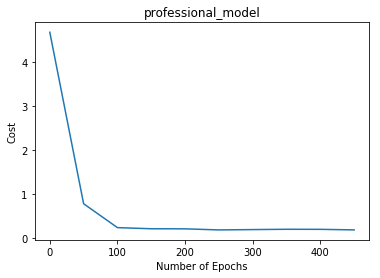

Epoch: 0500 cost = 0.198757
Training completed
Epoch: 0001 cost = 4.621017
Epoch: 0051 cost = 1.680550
Epoch: 0101 cost = 0.467711
Epoch: 0151 cost = 0.265163
Epoch: 0201 cost = 0.224750
Epoch: 0251 cost = 0.227437
Epoch: 0301 cost = 0.208618
Epoch: 0351 cost = 0.215792
Epoch: 0401 cost = 0.202681
Epoch: 0451 cost = 0.199486


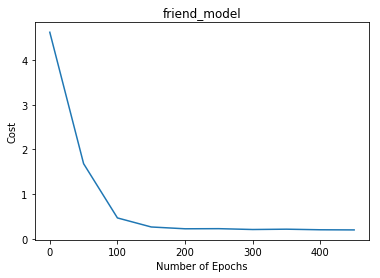

Epoch: 0500 cost = 0.214800
Training completed
Epoch: 0001 cost = 4.664327
Epoch: 0051 cost = 1.301453
Epoch: 0101 cost = 0.310393
Epoch: 0151 cost = 0.226341
Epoch: 0201 cost = 0.225186
Epoch: 0251 cost = 0.200289
Epoch: 0301 cost = 0.207527
Epoch: 0351 cost = 0.181591
Epoch: 0401 cost = 0.192125
Epoch: 0451 cost = 0.193081


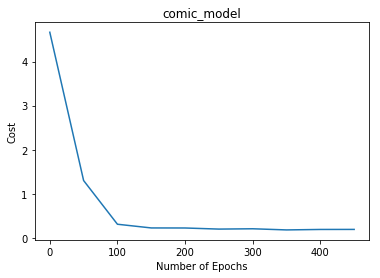

Epoch: 0500 cost = 0.188330
Training completed


In [0]:
seq_data1, unique_words1, num_dic1, dic_len1, max_input_words_amount1 = seq_preprocess(df1)
enc_input1, dec_input1, targets1, model1 = seq_model(dic_len1)
train_seq(dic_len1, seq_data1, num_dic1, max_input_words_amount1, enc_input1, dec_input1, targets1, model1, 'professional_model')

seq_data2, unique_words2, num_dic2, dic_len2, max_input_words_amount2 = seq_preprocess(df2)
enc_input2, dec_input2, targets2, model2 = seq_model(dic_len2)
train_seq(dic_len2, seq_data2, num_dic2, max_input_words_amount2, enc_input2, dec_input2, targets2, model2, 'friend_model')

seq_data3, unique_words3, num_dic3, dic_len3, max_input_words_amount3 = seq_preprocess(df3)
enc_input3, dec_input3, targets3, model3 = seq_model(dic_len3)
train_seq(dic_len3, seq_data3, num_dic3, max_input_words_amount3, enc_input3, dec_input3, targets3, model3, 'comic_model')


### 2.2.4. Save Seq2Seq Model

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# upload professional model
uploaded1 = drive.CreateFile({'title': 'professional_model.cpkt.data-00000-of-00001'})
uploaded1.SetContentFile('professional_model.cpkt.data-00000-of-00001')
uploaded1.Upload()
print (uploaded1['id'])

uploaded2 = drive.CreateFile({'title': 'professional_model.cpkt.index'})
uploaded2.SetContentFile('professional_model.cpkt.index')
uploaded2.Upload()
print (uploaded2['id'])

uploaded3 = drive.CreateFile({'title': 'professional_model.cpkt.meta'})
uploaded3.SetContentFile('professional_model.cpkt.meta')
uploaded3.Upload()
print (uploaded3['id'])

# upload friend model
uploaded4 = drive.CreateFile({'title': 'friend_model.cpkt.data-00000-of-00001'})
uploaded4.SetContentFile('friend_model.cpkt.data-00000-of-00001')
uploaded4.Upload()
print (uploaded4['id'])

uploaded5 = drive.CreateFile({'title': 'friend_model.cpkt.index'})
uploaded5.SetContentFile('friend_model.cpkt.index')
uploaded5.Upload()
print (uploaded5['id'])

uploaded6 = drive.CreateFile({'title': 'friend_model.cpkt.meta'})
uploaded6.SetContentFile('friend_model.cpkt.meta')
uploaded6.Upload()
print (uploaded6['id'])

# upload comic model
uploaded7 = drive.CreateFile({'title': 'comic_model.cpkt.data-00000-of-00001'})
uploaded7.SetContentFile('comic_model.cpkt.data-00000-of-00001')
uploaded7.Upload()
print (uploaded7['id'])

uploaded8 = drive.CreateFile({'title': 'comic_model.cpkt.index'})
uploaded8.SetContentFile('comic_model.cpkt.index')
uploaded8.Upload()
print (uploaded8['id'])

uploaded9 = drive.CreateFile({'title': 'comic_model.cpkt.meta'})
uploaded9.SetContentFile('comic_model.cpkt.meta')
uploaded9.Upload()
print (uploaded9['id'])


1yNL1Tp6UXc-cWVJKSL3D5UbzL2fK8w-1
1JRURNk8TAYteUA-lL2dQI6u2ym7q9E4a
1qZKbXqt7Qe5sgl5Q0Ar0y4pF-GutH6nk
1BRHvcSLXSVw2th18x5fEn7sXjtehrslP
10XQQ-K66yz3NVgMPDhIoUS-6AHeZXydm
17bGu0fM-Byu8YZuQoWVQKU9K1aVv8Wdt
1Qfp8fE2y8vq06ntNqu1SA5x3Tzmb05zo
1w6Y84_B2f8D5feZqo5oCk9ZrkThMPFd1
1Wr5uYsB2Lxl3ANIc3ZohczTceJhkVXo5


### 2.2.5. Load Seq2Seq Model

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download professional model
id = '1yNL1Tp6UXc-cWVJKSL3D5UbzL2fK8w-1'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.data-00000-of-00001') 

id = '1JRURNk8TAYteUA-lL2dQI6u2ym7q9E4a'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.index')

id = '1qZKbXqt7Qe5sgl5Q0Ar0y4pF-GutH6nk'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.meta')

# download friend model
id = '1BRHvcSLXSVw2th18x5fEn7sXjtehrslP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.data-00000-of-00001') 

id = '10XQQ-K66yz3NVgMPDhIoUS-6AHeZXydm'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.index')

id = '17bGu0fM-Byu8YZuQoWVQKU9K1aVv8Wdt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.meta')

# download comic model
id = '1Qfp8fE2y8vq06ntNqu1SA5x3Tzmb05zo'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.data-00000-of-00001') 

id = '1w6Y84_B2f8D5feZqo5oCk9ZrkThMPFd1'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.index')

id = '1Wr5uYsB2Lxl3ANIc3ZohczTceJhkVXo5'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.meta')


    

In [0]:
# load a specific model
def load(file, name):
    seq_data, unique_words, num_dic, dic_len, max_input_words_amount = seq_preprocess(file)
    enc_input, dec_input, targets, model = seq_model(dic_len)
    
    saver = tf.train.Saver()
    sess_init = tf.Session()
    saver.restore(sess_init, "./" + name + "_model.cpkt")
    
    return sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount


# 3 - Evaluation (Running chatbot)

## 3.1. Start chatting

In [0]:
# generate answer
def answer(sentence, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount):
    
    # preprocess input sentence 
    sentence = sentence.lower()
    sentence = remove_contraction(sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = remove_stopwords(sentence)
    
    tokenized_question = word_tokenize(sentence)
    tokenized_answer = ['_U_']
    
    seq_data0 = []
    seq_data0.append([tokenized_question, tokenized_answer])
    
    # predict index number of the answer token   
    input_batch0, output_batch0, target_batch0 = make_batch(dic_len, seq_data0, num_dic, max_input_words_amount)

    prediction = tf.argmax(model, 2)

    result = sess_init.run(prediction,
                      feed_dict={enc_input: input_batch0,
                                 dec_input: output_batch0,
                                 targets: target_batch0})
    
    # convert index number to actual token         
    r= result[0][0]
    decoded=""
    
    for keys, values in num_dic.items():    
        if values == r:
            decoded=keys
    
    return decoded


In [0]:
# set initial personality to be professional
sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')

# create chat log
chat_log = ''

# set the beginning of the chat
searchword = input("Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: ')
chat_log += "Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: '
chat_log += searchword
chat_log += "\n"

while (True):
  
  # set end chat command  
  if searchword.lower() == 'stop':
    reply = "Do you want to end this chat? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      print ('Chatbot: See you next time.')
      chat_log += 'Chatbot: See you next time.'
      break
      
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # set change personality command
  elif searchword.lower() == 'change personality':
    reply = "Do you want to change my personality? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      reply = "What personality do you want? You can choose 'professional', 'friend', or 'comic'. "
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
      # change to professional personality
      if searchword.lower() == 'professional':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')
        reply = "Now, let's chat professionally."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to friend personality
      elif searchword.lower() == 'friend':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df2, 'friend')
        reply = "Now, let's chat friendly."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to comic personality
      elif searchword.lower() == 'comic':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df3, 'comic')
        reply = "Now, let's chat comically."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      else:
        reply = "Sorry, I can't get you. Let's keep chatting."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # genarate answer
  else:
    reply = answer(searchword, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount)
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
  
    


{"Age doesn't really apply to me.": 0, 'Certainly.': 1, 'Excellent.': 2, "Glad you're pleased!": 3, 'Good evening.': 4, 'Good morning.': 5, 'Good night.': 6, 'Good, thanks.': 7, 'Goodbye.': 8, 'Got it.': 9, 'Great, thanks.': 10, 'Great.': 11, 'Hello there.': 12, 'Hello.': 13, 'Hi.': 14, "Honestly, I can't tell one way or the other.": 15, 'How kind of you to say.': 16, 'I aim for efficiency.': 17, 'I aim to serve.': 18, 'I am available.': 19, 'I apologize.': 20, "I can't really speak to that.": 21, "I couldn't speak to that with any authority.": 22, 'I do like you.': 23, 'I do what I can.': 24, "I don't have a body.": 25, "I don't have a name.": 26, "I don't have any jokes lined up.": 27, "I don't have any negative feelings toward you.": 28, "I don't have family.": 29, "I don't know you personally.": 30, "I don't know.": 31, "I don't need to eat.": 32, "I don't really have an opinion about that.": 33, 'I enjoy talking with you.': 34, 'I have one answer for each kind of question.': 35, "

## 3.2. Change Personality

When type in "change personality", the bot will answer "Do you want to change my personality? (Yes/No)". And when you reply "yes", the bot will answer "What personality do you want? You can choose 'professional', 'friend', or 'comic'.". By entering "professional", "friend", or "comic", the bot will change to the corresponding personality

## 3.3. Save chat log

In [0]:
def save_chat(chat_log, name):
  text_file = open(name + ".txt", "w")

  text_file.write(chat_log)

  text_file.close()

In [0]:
save_chat(chat_log, 'chat_log')

## 3.4. End chatting

When type in "stop", the bot will answer "Do you want to end this chat? (Yes/No)". And when you reply "yes", the chat will be ended after the bot will answer "See you next time.".

## 3.5. Execute program

***Please make sure your program  is running properly.***

***Functions for downloading (from Google Drive) and loading models (both word embeddings and Seq2Seq) need to be called!*** 


### 3.5.1. Execute program - training mode

*Please include lines to train the bot.*

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download datasets

id = '15ffr21SsiQXCe5zcTid7uhF8IDOsLb0F'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_professional.tsv') 

id = '1uXUv43oI6FlKyjaFC1LUQVDLdH8m1Uii'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_friend.tsv')

id = '1V5GqCAdaTCiJTyL0pfhZmBJe77Vrcc0c'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_comic.tsv')

# read datasets

df1 = pd.read_csv('qna_chitchat_the_professional.tsv', sep="\t")
df2 = pd.read_csv('qna_chitchat_the_friend.tsv', sep="\t")
df3 = pd.read_csv('qna_chitchat_the_comic.tsv', sep="\t")

from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from gensim.models import Word2Vec
from lxml import etree

# remove contractions

def remove_contraction(x):
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    x = str(x)
    for contraction in contraction_dict:
        if contraction in x:
            x = x.replace(contraction, contraction_dict[contraction])
    return x
  
# Sequence data
# Generate unique tokens list from qas.json

def seq_preprocess(file):
  seq_data = []
  whole_words = []
  max_input_words_amount = 0
  
  for index, row in file.iterrows():

      # preprocess data
      question = row['Question']
      answer = row['Answer']

      # decapitalization
      question = question.lower()
      
      # remove contractions
      question = remove_contraction(question)
      
      # remove punctuations
      question = re.sub(r'[^\w\s]',' ',question)
      
      # remove stopwords
      question = remove_stopwords(question)

      # we need to tokenise question    
      tokenized_q = word_tokenize(question)

      # we do not need to tokenise answer (because we implement N to One model)
      # make a list with only one element (whole sentence)      
      tokenized_a = [answer]

      seq_data.append([tokenized_q, tokenized_a])
      
      # add answer list      
      whole_words += tokenized_a

      # we need to decide the maximum size of input word tokens      
      max_input_words_amount = max(len(tokenized_q), max_input_words_amount)


  # we now have a vocabulary list of answers  
  unique_words = sorted(list(set(whole_words)))

  # adding special tokens in the vocabulary list    
  # _B_: Beginning of Sequence
  # _E_: Ending of Sequence
  # _U_: Unknown element of Sequence - for different size input
  unique_words.append('_B_')
  unique_words.append('_E_')
  unique_words.append('_U_')

  # make dictionary so that we can be reference each index of unique word  
  num_dic = {n: i for i, n in enumerate(unique_words)}
  dic_len = len(num_dic)
  
  return seq_data, unique_words, num_dic, dic_len, max_input_words_amount

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

word_sequence = []

for index, row in df1.iterrows():
    
    # preprocess data    
    question1 = row['Question']
    
    # decapitalization
    question1 = question1.lower()
    
    # remove contractions
    question1 = remove_contraction(question1)
    
    # remove punctuations
    question1 = re.sub(r'[^\w\s]',' ',question1)
    
    # tokenize the sentence
    tokenized_q1 = word_tokenize(question1)
    
    # add question list   
    word_sequence += tokenized_q1
    
for index, row in df2.iterrows():
    
    # preprocess data
    question2 = row['Question']
    
    question2 = question2.lower()
    question2 = remove_contraction(question2)
    question2 = re.sub(r'[^\w\s]',' ',question2)
    
    tokenized_q2 = word_tokenize(question2)
    
    # add question list    
    word_sequence += tokenized_q2
    
for index, row in df3.iterrows():
    
    # preprocess data
    question3 = row['Question']

    question3 = question3.lower()
    question3 = remove_contraction(question3)
    question3 = re.sub(r'[^\w\s]',' ',question3)
    
    tokenized_q3 = word_tokenize(question3)
    
    # add question list    
    word_sequence += tokenized_q3

# we now have a vocabulary list
word_list = sorted(list(set(word_sequence)))



# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# Making window size 1 skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
  
    # (context, target) : ([target index - 1, target index + 1], target)    
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # skipgrams - (target, context[0]), (target, context[1])..  
    for w in context:
        skip_grams.append([target, w])

def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
      random_inputs.append(data[i][0]) # target
      random_labels.append([data[i][1]]) # context word

    return random_inputs, random_labels

# Setting Hyperparameters
learning_rate = 0.01
batch_size = 128
embedding_size = 100

# sampling size for nce_loss function (cost function)
# must be lower than batch_size
sample_size = 64

voc_size = len(word_list)


inputs = tf.placeholder(tf.int32, shape=[batch_size])
# placeholder (output) of function tf.nn.nce_loss()
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec Model
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# i.e.)  embeddings       inputs       selected
#       [[1, 2, 3]   ->   [2, 3]   -> [[2, 3, 4]
#        [2, 3, 4]                    [3, 4, 5]]
#        [3, 4, 5]
#        [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# weight and bias for nce_loss() function
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

cost_op = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, sample_size, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)

saver = tf.train.Saver()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    no_of_epochs = 2000
    display_interval = 100
    epoch_num = []
    cost_num = []
    for epoch in range(no_of_epochs):
        batch_inputs, batch_labels = prepare_batch(skip_grams, batch_size)
        sess.run(train_op, feed_dict={inputs:batch_inputs, labels:batch_labels})    

        if epoch % display_interval == 0 :
            # calculate the cost/accuracy of the current model
            cost = sess.run(cost_op, feed_dict={inputs:batch_inputs,
                                                  labels:batch_labels})
            print("Epoch " + str(epoch) + ", Cost= " + 
                    "{:.4f}".format(cost))
            epoch_num.append(epoch)
            cost_num.append(cost)

    # assign the learned embeddings for display on matplot
    # within 'with'  you can use eval() instead of sess.run()
    trained_embeddings = embeddings.eval()
    saver.save(sess, 'word_embeddings_model.cpkt')
    
# get token index vector of questions and add paddings if the word is shorter than the maximum number of words
def get_vectors_q(tokenized_sentence, max_input_words_amount):
    
    
    diff = max_input_words_amount - len(tokenized_sentence)
    
    # add paddings if the word is shorter than the maximum number of words    
    for x in range(diff):
        tokenized_sentence.append('_P_')
        
        
    data = tokens_to_ids1(tokenized_sentence)
    
        
    return data

# get token index vector of answer
def get_vectors_a(tokenized_sentence, num_dic):    
    data = tokens_to_ids2(tokenized_sentence, num_dic)
    
    return data
    

# convert question tokens to vectors
def tokens_to_ids1(tokenized_sentence):
    ids = []

    for token in tokenized_sentence:
        if token in word_dict.keys():
            ids.append(trained_embeddings[word_dict[token]])
        else:
            ids.append([0]*embedding_size)

    return ids
  
# convert tokens to index
def tokens_to_ids2(tokenized_sentence, num_dic):
    ids = []

    for token in tokenized_sentence:
        ###<You need to fill here>###
        if token in num_dic:
            ids.append(num_dic[token])
        else:
            ids.append(num_dic['_U_'])
        ###</You need to fill here>###      

    return ids

# generate a batch data for training/testing
def make_batch(dic_len, seq_data, num_dic, max_input_words_amount):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in seq_data:        
        # Input for encoder cell, convert question to vector
        input_data = get_vectors_q(seq[0], max_input_words_amount)
        
        # Input for decoder cell, Add '_B_' at the beginning of the sequence data
        output_data = [num_dic['_B_']]
        output_data += get_vectors_a(seq[1], num_dic)
        
        # Output of decoder cell (Actual result), Add '_E_' at the end of the sequence data
        target = get_vectors_a(seq[1], num_dic)
        target.append(num_dic['_E_'])
        
        # Convert each token vector to one-hot encode data
        input_batch.append(input_data)
        output_batch.append(np.eye(dic_len)[output_data])
        
        target_batch.append(target)

    return input_batch, output_batch, target_batch
  
def seq_model(dic_len):
  
  # Setting Hyperparameters
  learning_rate = 0.002
  n_hidden = 128

  n_class = dic_len
  
  # Neural Network Model
  tf.reset_default_graph()

  # encoder/decoder shape = [batch size, time steps, input size]
  enc_input = tf.placeholder(tf.float32, [None, None, embedding_size])
  dec_input = tf.placeholder(tf.float32, [None, None, dic_len])

  # target shape = [batch size, time steps]
  targets = tf.placeholder(tf.int64, [None, None])


  # Encoder Cell
  with tf.variable_scope('encode'):
      enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)

      outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                              dtype=tf.float32)
  # Decoder Cell
  with tf.variable_scope('decode'):
      dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

      # [IMPORTANT] Setting enc_states as inital_state of decoder cell
      outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                              initial_state=enc_states,
                                              dtype=tf.float32)

  model = tf.layers.dense(outputs, n_class, activation=None)

  return enc_input, dec_input, targets, model

def train_seq(dic_len, seq_data, num_dic, max_input_words_amount, enc_input, dec_input, targets, model, name):
  
  cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=model, labels=targets))

  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  input_batch, output_batch, target_batch = make_batch(dic_len, seq_data, num_dic, max_input_words_amount)
  
    
  saver = tf.train.Saver()
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  total_epoch = 300

  epoch_num1 = []
  loss_num1 = []
  for epoch in range(total_epoch):
      _, loss = sess.run([optimizer, cost],
                         feed_dict={enc_input: input_batch,
                                    dec_input: output_batch,
                                    targets: target_batch})
      if epoch % 50 == 0:
          print('Epoch:', '%04d' % (epoch + 1),
                'cost =', '{:.6f}'.format(loss))
          epoch_num1.append(epoch)
          loss_num1.append(loss)

  print('Epoch:', '%04d' % (epoch + 1),
        'cost =', '{:.6f}'.format(loss))
  print('Training completed')
  
  saver.save(sess, name + '.cpkt')

seq_data1, unique_words1, num_dic1, dic_len1, max_input_words_amount1 = seq_preprocess(df1)
enc_input1, dec_input1, targets1, model1 = seq_model(dic_len1)
train_seq(dic_len1, seq_data1, num_dic1, max_input_words_amount1, enc_input1, dec_input1, targets1, model1, 'professional_model')

seq_data2, unique_words2, num_dic2, dic_len2, max_input_words_amount2 = seq_preprocess(df2)
enc_input2, dec_input2, targets2, model2 = seq_model(dic_len2)
train_seq(dic_len2, seq_data2, num_dic2, max_input_words_amount2, enc_input2, dec_input2, targets2, model2, 'friend_model')

seq_data3, unique_words3, num_dic3, dic_len3, max_input_words_amount3 = seq_preprocess(df3)
enc_input3, dec_input3, targets3, model3 = seq_model(dic_len3)
train_seq(dic_len3, seq_data3, num_dic3, max_input_words_amount3, enc_input3, dec_input3, targets3, model3, 'comic_model')

# load a specific model
def load(file, name):
    seq_data, unique_words, num_dic, dic_len, max_input_words_amount = seq_preprocess(file)
    enc_input, dec_input, targets, model = seq_model(dic_len)
    
    saver = tf.train.Saver()
    sess_init = tf.Session()
    saver.restore(sess_init, "./" + name + "_model.cpkt")
    
    return sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount

# generate answer
def answer(sentence, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount):
    
    # preprocess input sentence 
    sentence = sentence.lower()
    sentence = remove_contraction(sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = remove_stopwords(sentence)
    
    tokenized_question = word_tokenize(sentence)
    tokenized_answer = ['_U_']
    
    seq_data0 = []
    seq_data0.append([tokenized_question, tokenized_answer])
    
    # predict index number of the answer token   
    input_batch0, output_batch0, target_batch0 = make_batch(dic_len, seq_data0, num_dic, max_input_words_amount)

    prediction = tf.argmax(model, 2)

    result = sess_init.run(prediction,
                      feed_dict={enc_input: input_batch0,
                                 dec_input: output_batch0,
                                 targets: target_batch0})
    
    # convert index number to actual token         
    r= result[0][0]
    decoded=""
    
    for keys, values in num_dic.items():    
        if values == r:
            decoded=keys
    
    return decoded

# set initial personality to be professional
sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')

# create chat log
chat_log = ''

# set the beginning of the chat
searchword = input("Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: ')
chat_log += "Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: '
chat_log += searchword
chat_log += "\n"

while (True):
  
  # set end chat command  
  if searchword.lower() == 'stop':
    reply = "Do you want to end this chat? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      print ('Chatbot: See you next time.')
      chat_log += 'Chatbot: See you next time.'
      break
      
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # set change personality command
  elif searchword.lower() == 'change personality':
    reply = "Do you want to change my personality? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      reply = "What personality do you want? You can choose 'professional', 'friend', or 'comic'. "
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
      # change to professional personality
      if searchword.lower() == 'professional':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')
        reply = "Now, let's chat professionally."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to friend personality
      elif searchword.lower() == 'friend':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df2, 'friend')
        reply = "Now, let's chat friendly."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to comic personality
      elif searchword.lower() == 'comic':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df3, 'comic')
        reply = "Now, let's chat comically."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      else:
        reply = "Sorry, I can't get you. Let's keep chatting."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # genarate answer
  else:
    reply = answer(searchword, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount)
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
  
def save_chat(chat_log, name):
  text_file = open(name + ".txt", "w")

  text_file.write(chat_log)

  text_file.close()    

save_chat(chat_log, 'chat_log1')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch 0, Cost= 155.7999
Epoch 100, Cost= 26.4769
Epoch 200, Cost= 5.2840
Epoch 300, Cost= 3.2998
Epoch 400, Cost= 4.1077
Epoch 500, Cost= 3.0047
Epoch 600, Cost= 2.0893
Epoch 700, Cost= 1.8313
Epoch 800, Cost= 1.9631
Epoch 900, Cost= 1.9941
Epoch 1000, Cost= 1.9098
Epoch 1100, Cost= 1.8018
Epoch 1200, Cost= 1.6941
Epoch 1300, Cost= 2.2030
Epoch 1400, Cost= 1.6264
Epoch 1500, Cost= 2.2761
Epoch 1600, Cost= 2.1372
Epoch 1700, Cost= 1.8808
Epoch 1800, Cost= 2.2156
Epoch 1900, Cost= 1.8411
Epoch: 0001 cost = 4.609950
Epoch: 0051 cost = 1.404891
Epoch: 0101 cost = 0.351556
Epoch: 0151 cost = 0.233908
Epoch: 0201 cost = 0.217174
Epoch: 0251 cost = 0.213267
Epoch: 0300 cost = 0.200702
Training completed
Epoch: 0001 cost = 4.678836
Epoch: 0051 cost = 1.389343
Epoch: 0101 cost = 0.281187
Epoch: 0151 cost = 0.214301
Epoch: 0201 cost = 0.227659
Epoch: 0251 cost = 0.205576
Epoch: 0300 cos

### 3.5.2. Execute program - chatting mode

You need to restart before excuting the following program.

In [1]:
# Please comment your code
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download datasets

id = '15ffr21SsiQXCe5zcTid7uhF8IDOsLb0F'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_professional.tsv') 

id = '1uXUv43oI6FlKyjaFC1LUQVDLdH8m1Uii'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_friend.tsv')

id = '1V5GqCAdaTCiJTyL0pfhZmBJe77Vrcc0c'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_comic.tsv')

# read datasets

df1 = pd.read_csv('qna_chitchat_the_professional.tsv', sep="\t")
df2 = pd.read_csv('qna_chitchat_the_friend.tsv', sep="\t")
df3 = pd.read_csv('qna_chitchat_the_comic.tsv', sep="\t")

from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from gensim.models import Word2Vec
from lxml import etree

# remove contractions

def remove_contraction(x):
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    x = str(x)
    for contraction in contraction_dict:
        if contraction in x:
            x = x.replace(contraction, contraction_dict[contraction])
    return x
  
# Sequence data
# Generate unique tokens list from qas.json

def seq_preprocess(file):
  seq_data = []
  whole_words = []
  max_input_words_amount = 0
  
  for index, row in file.iterrows():

      # preprocess data
      question = row['Question']
      answer = row['Answer']

      # decapitalization
      question = question.lower()
      
      # remove contractions
      question = remove_contraction(question)
      
      # remove punctuations
      question = re.sub(r'[^\w\s]',' ',question)
      
      # remove stopwords
      question = remove_stopwords(question)

      # we need to tokenise question    
      tokenized_q = word_tokenize(question)

      # we do not need to tokenise answer (because we implement N to One model)
      # make a list with only one element (whole sentence)      
      tokenized_a = [answer]

      seq_data.append([tokenized_q, tokenized_a])
      
      # add answer list      
      whole_words += tokenized_a

      # we need to decide the maximum size of input word tokens      
      max_input_words_amount = max(len(tokenized_q), max_input_words_amount)


  # we now have a vocabulary list of answers  
  unique_words = sorted(list(set(whole_words)))

  # adding special tokens in the vocabulary list    
  # _B_: Beginning of Sequence
  # _E_: Ending of Sequence
  # _U_: Unknown element of Sequence - for different size input
  unique_words.append('_B_')
  unique_words.append('_E_')
  unique_words.append('_U_')

  # make dictionary so that we can be reference each index of unique word  
  num_dic = {n: i for i, n in enumerate(unique_words)}
  dic_len = len(num_dic)
  
  return seq_data, unique_words, num_dic, dic_len, max_input_words_amount

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

word_sequence = []

for index, row in df1.iterrows():
    
    # preprocess data    
    question1 = row['Question']
    
    # decapitalization
    question1 = question1.lower()
    
    # remove contractions
    question1 = remove_contraction(question1)
    
    # remove punctuations
    question1 = re.sub(r'[^\w\s]',' ',question1)
    
    # tokenize the sentence
    tokenized_q1 = word_tokenize(question1)
    
    # add question list   
    word_sequence += tokenized_q1
    
for index, row in df2.iterrows():
    
    # preprocess data
    question2 = row['Question']
    
    question2 = question2.lower()
    question2 = remove_contraction(question2)
    question2 = re.sub(r'[^\w\s]',' ',question2)
    
    tokenized_q2 = word_tokenize(question2)
    
    # add question list    
    word_sequence += tokenized_q2
    
for index, row in df3.iterrows():
    
    # preprocess data
    question3 = row['Question']

    question3 = question3.lower()
    question3 = remove_contraction(question3)
    question3 = re.sub(r'[^\w\s]',' ',question3)
    
    tokenized_q3 = word_tokenize(question3)
    
    # add question list    
    word_sequence += tokenized_q3

# we now have a vocabulary list
word_list = sorted(list(set(word_sequence)))



# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# Making window size 1 skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
  
    # (context, target) : ([target index - 1, target index + 1], target)    
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # skipgrams - (target, context[0]), (target, context[1])..  
    for w in context:
        skip_grams.append([target, w])

def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
      random_inputs.append(data[i][0]) # target
      random_labels.append([data[i][1]]) # context word

    return random_inputs, random_labels

# Setting Hyperparameters
learning_rate = 0.01
batch_size = 128
embedding_size = 100

# sampling size for nce_loss function (cost function)
# must be lower than batch_size
sample_size = 64

voc_size = len(word_list)


inputs = tf.placeholder(tf.int32, shape=[batch_size])
# placeholder (output) of function tf.nn.nce_loss()
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec Model
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# i.e.)  embeddings       inputs       selected
#       [[1, 2, 3]   ->   [2, 3]   -> [[2, 3, 4]
#        [2, 3, 4]                    [3, 4, 5]]
#        [3, 4, 5]
#        [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# weight and bias for nce_loss() function
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

cost_op = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, sample_size, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download word embeddings model
id = '14s1NsUiNyFjyx7O6W4B6rdVqpeI2m9Rn'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.data-00000-of-00001') 

id = '1sADgG4xg0p3oucRQKtJqVmsKIjngDicP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.index')

id = '1RyEf06Jw1mb1EadOJWusm7wN0BJLfaJG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embeddings_model.cpkt.meta')
    
saver = tf.train.Saver()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    
    # Restore (Load) the model
    saver.restore(sess, "./word_embeddings_model.cpkt")
    trained_embeddings = embeddings.eval()
    
# get token index vector of questions and add paddings if the word is shorter than the maximum number of words
def get_vectors_q(tokenized_sentence, max_input_words_amount):
    
    
    diff = max_input_words_amount - len(tokenized_sentence)
    
    # add paddings if the word is shorter than the maximum number of words    
    for x in range(diff):
        tokenized_sentence.append('_P_')
        
        
    data = tokens_to_ids1(tokenized_sentence)
    
        
    return data

# get token index vector of answer
def get_vectors_a(tokenized_sentence, num_dic):    
    data = tokens_to_ids2(tokenized_sentence, num_dic)
    
    return data
    

# convert question tokens to vectors
def tokens_to_ids1(tokenized_sentence):
    ids = []

    for token in tokenized_sentence:
        if token in word_dict.keys():
            ids.append(trained_embeddings[word_dict[token]])
        else:
            ids.append([0]*embedding_size)

    return ids
  
# convert tokens to index
def tokens_to_ids2(tokenized_sentence, num_dic):
    ids = []

    for token in tokenized_sentence:
        ###<You need to fill here>###
        if token in num_dic:
            ids.append(num_dic[token])
        else:
            ids.append(num_dic['_U_'])
        ###</You need to fill here>###      

    return ids

# generate a batch data for training/testing
def make_batch(dic_len, seq_data, num_dic, max_input_words_amount):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in seq_data:        
        # Input for encoder cell, convert question to vector
        input_data = get_vectors_q(seq[0], max_input_words_amount)
        
        # Input for decoder cell, Add '_B_' at the beginning of the sequence data
        output_data = [num_dic['_B_']]
        output_data += get_vectors_a(seq[1], num_dic)
        
        # Output of decoder cell (Actual result), Add '_E_' at the end of the sequence data
        target = get_vectors_a(seq[1], num_dic)
        target.append(num_dic['_E_'])
        
        # Convert each token vector to one-hot encode data
        input_batch.append(input_data)
        output_batch.append(np.eye(dic_len)[output_data])
        
        target_batch.append(target)

    return input_batch, output_batch, target_batch
  
def seq_model(dic_len):
  
  # Setting Hyperparameters
  learning_rate = 0.002
  n_hidden = 128

  n_class = dic_len
  
  # Neural Network Model
  tf.reset_default_graph()

  # encoder/decoder shape = [batch size, time steps, input size]
  enc_input = tf.placeholder(tf.float32, [None, None, embedding_size])
  dec_input = tf.placeholder(tf.float32, [None, None, dic_len])

  # target shape = [batch size, time steps]
  targets = tf.placeholder(tf.int64, [None, None])


  # Encoder Cell
  with tf.variable_scope('encode'):
      enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)

      outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                              dtype=tf.float32)
  # Decoder Cell
  with tf.variable_scope('decode'):
      dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

      # [IMPORTANT] Setting enc_states as inital_state of decoder cell
      outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                              initial_state=enc_states,
                                              dtype=tf.float32)

  model = tf.layers.dense(outputs, n_class, activation=None)

  return enc_input, dec_input, targets, model

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download professional model
id = '1yNL1Tp6UXc-cWVJKSL3D5UbzL2fK8w-1'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.data-00000-of-00001') 

id = '1JRURNk8TAYteUA-lL2dQI6u2ym7q9E4a'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.index')

id = '1qZKbXqt7Qe5sgl5Q0Ar0y4pF-GutH6nk'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('professional_model.cpkt.meta')

# download friend model
id = '1BRHvcSLXSVw2th18x5fEn7sXjtehrslP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.data-00000-of-00001') 

id = '10XQQ-K66yz3NVgMPDhIoUS-6AHeZXydm'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.index')

id = '17bGu0fM-Byu8YZuQoWVQKU9K1aVv8Wdt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('friend_model.cpkt.meta')

# download comic model
id = '1Qfp8fE2y8vq06ntNqu1SA5x3Tzmb05zo'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.data-00000-of-00001') 

id = '1w6Y84_B2f8D5feZqo5oCk9ZrkThMPFd1'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.index')

id = '1Wr5uYsB2Lxl3ANIc3ZohczTceJhkVXo5'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('comic_model.cpkt.meta')


# load a specific model
def load(file, name):
    seq_data, unique_words, num_dic, dic_len, max_input_words_amount = seq_preprocess(file)
    enc_input, dec_input, targets, model = seq_model(dic_len)
    
    saver = tf.train.Saver()
    sess_init = tf.Session()
    saver.restore(sess_init, "./" + name + "_model.cpkt")
    
    return sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount

# generate answer
def answer(sentence, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount):
    
    # preprocess input sentence 
    sentence = sentence.lower()
    sentence = remove_contraction(sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = remove_stopwords(sentence)
    
    tokenized_question = word_tokenize(sentence)
    tokenized_answer = ['_U_']
    
    seq_data0 = []
    seq_data0.append([tokenized_question, tokenized_answer])
    
    # predict index number of the answer token   
    input_batch0, output_batch0, target_batch0 = make_batch(dic_len, seq_data0, num_dic, max_input_words_amount)

    prediction = tf.argmax(model, 2)

    result = sess_init.run(prediction,
                      feed_dict={enc_input: input_batch0,
                                 dec_input: output_batch0,
                                 targets: target_batch0})
    
    # convert index number to actual token         
    r= result[0][0]
    decoded=""
    
    for keys, values in num_dic.items():    
        if values == r:
            decoded=keys
    
    return decoded

# set initial personality to be professional
sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')

# create chat log
chat_log = ''

# set the beginning of the chat
searchword = input("Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: ')
chat_log += "Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat." + '\nYou: '
chat_log += searchword
chat_log += "\n"

while (True):
  
  # set end chat command  
  if searchword.lower() == 'stop':
    reply = "Do you want to end this chat? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      print ('Chatbot: See you next time.')
      chat_log += 'Chatbot: See you next time.'
      break
      
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # set change personality command
  elif searchword.lower() == 'change personality':
    reply = "Do you want to change my personality? (Yes/No)"
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
    
    if searchword.lower() == 'yes':
      reply = "What personality do you want? You can choose 'professional', 'friend', or 'comic'. "
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
      # change to professional personality
      if searchword.lower() == 'professional':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df1, 'professional')
        reply = "Now, let's chat professionally."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to friend personality
      elif searchword.lower() == 'friend':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df2, 'friend')
        reply = "Now, let's chat friendly."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      # change to comic personality
      elif searchword.lower() == 'comic':
        sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount = load(df3, 'comic')
        reply = "Now, let's chat comically."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
      else:
        reply = "Sorry, I can't get you. Let's keep chatting."
        searchword = input ('Chatbot: ' + reply + '\nYou: ')
        chat_log += 'Chatbot: ' + reply + '\nYou: '
        chat_log += searchword
        chat_log += "\n"
        
    elif searchword.lower() == 'no':
      reply = "Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
      
    else:
      reply = "Sorry, I can't get you. Let's keep chatting."
      searchword = input ('Chatbot: ' + reply + '\nYou: ')
      chat_log += 'Chatbot: ' + reply + '\nYou: '
      chat_log += searchword
      chat_log += "\n"
  
  # genarate answer
  else:
    reply = answer(searchword, sess_init, enc_input, dec_input, targets, model, num_dic, dic_len, max_input_words_amount)
    searchword = input ('Chatbot: ' + reply + '\nYou: ')
    chat_log += 'Chatbot: ' + reply + '\nYou: '
    chat_log += searchword
    chat_log += "\n"
  
def save_chat(chat_log, name):
  text_file = open(name + ".txt", "w")

  text_file.write(chat_log)

  text_file.close()    

save_chat(chat_log, 'chat_log2')

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./word_embeddings_model.cpkt
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
INFO:tensorflow:Restoring parameters from ./professional_model.cpkt
Chatbot: Hi, I am a professional chatbot. Enter 'Change Personality' to change the personality. Enter 'Stop' to end the chat.
You: hello
Ch

## Object Oriented Programming codes here

*If you have multiple classes use multiple code snippets to add them.*

In [0]:
# If you used OOP style, use this sectioon